# Stance Classification In Tweets

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import keras
import re
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Convolution2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from statsmodels.graphics.mosaicplot import mosaic
tf.keras.optimizers.RMSprop
get_ipython().run_line_magic('matplotlib', 'inline')
import os
tf.__version__

Using TensorFlow backend.


'2.0.2'

## Upload and unzip data file

In [2]:
import zipfile
with zipfile.ZipFile('./StanceDataset.zip', 'r') as zip_ref:
 zip_ref.extractall('./')

## Reading training data

In [3]:
train = pd.read_csv('./StanceDataset/train.csv', index_col=None, header=0, engine='python' )

## Understand Data and Preprocessing

In [4]:
train.shape

(2914, 5)

## Checking shape of training data and creating a plot to analyse Bias in data

In [5]:
#grouping
shape_data_group_target= train.groupby(["Target"])
shape_data_group_plot_target= shape_data_group_target.count()

,Tweet,Stance,Opinion Towards,Sentiment
Target,,,,
Atheism,513,513,513,513
Climate Change is a Real Concern,395,395,395,395
Feminist Movement,664,664,664,664
Hillary Clinton,689,689,689,689
Legalization of Abortion,653,653,653,653


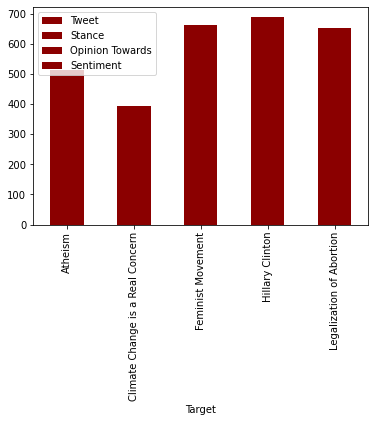

In [6]:
#plotting bar chart
shape_data_group_plot_target.plot(kind='bar',color=('darkred'))
shape_data_group_target.count()

,Tweet,Target,Opinion Towards,Sentiment
Stance,,,,
AGAINST,1395,1395,1395,1395
FAVOR,753,753,753,753
NONE,766,766,766,766


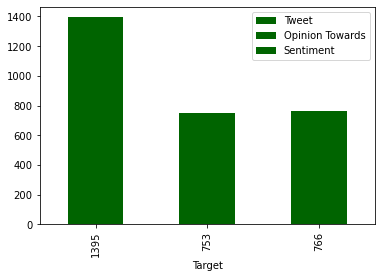

In [7]:
#grouping
shape_data_group_stance= train.groupby(["Stance"])
shape_data_group_plot_stance= shape_data_group_stance.count()
#plotting bar chart
shape_data_group_plot_stance.plot('Target',kind='bar',color=('darkgreen'))
shape_data_group_stance.count()

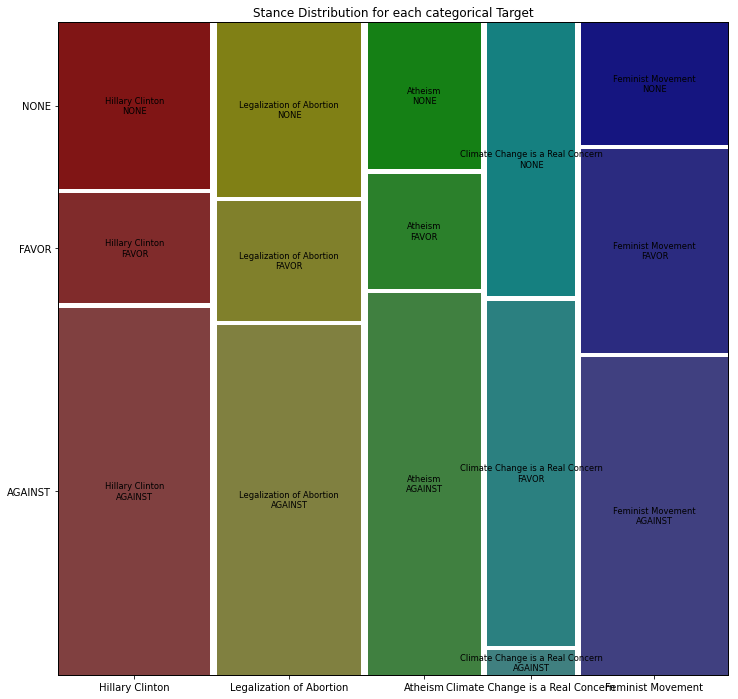

In [8]:
df1 = pd.DataFrame(train,columns=['Target','Stance'])

from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 10.0
plt.rcParams["figure.figsize"]=(12.0, 12.0)
mosaic(df1, ['Target', 'Stance'],gap=0.01,title='Stance Distribution for each categorical Target');


## Splitting Data into TRAIN, TEST AND VALIDATION

In [9]:

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(train,test_size = 0.2)
training_data, validation_data = train_test_split(train_data,test_size = 0.2)

# Generate two data frames for training and validation #
print('Train size: {}, Test size: {}'.format(training_data.shape[0], validation_data.shape[0] ) ) 
N_train = training_data.shape[0]
N_val = validation_data.shape[0]

Train size: 1864, Test size: 467


In [10]:
training_data.shape

(1864, 5)

In [11]:
test_data.shape

(583, 5)

In [12]:
validation_data.shape

(467, 5)

In [13]:
training_data

,Tweet,Target,Stance,Opinion Towards,Sentiment
1904,@HillaryClinton said #AllLivesMatter just like...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
888,"Clean technology, this is your moment #innovat...",Climate Change is a Real Concern,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2194,"@maddow I love Bern, but it's not his time! #S...",Hillary Clinton,AGAINST,2. The tweet does NOT expresses opinion about ...,other
1892,"America needs a champion!-H No thanks,@Hillar...",Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
2120,@HlLLARY @ToniforAsm Hillary for Prez = Obama'...,Hillary Clinton,AGAINST,2. The tweet does NOT expresses opinion about ...,neg
...,...,...,...,...,...
1816,@HillaryClinton Says the millionaire politicia...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
1660,"the Left 10 years ago ""Keep government out of ...",Feminist Movement,AGAINST,2. The tweet does NOT expresses opinion about ...,neg
729,"That #Putin chap must be extremely #confused, ...",Climate Change is a Real Concern,NONE,2. The tweet does NOT expresses opinion about ...,neg
534,"Instead of : ""Let's have a quick word of praye...",Atheism,AGAINST,2. The tweet does NOT expresses opinion about ...,pos


## Cleaning Data

In [14]:
training_data = training_data.applymap(str)

In [15]:
training_data["Tweet"] = training_data["Tweet"].apply(str)

In [16]:
training_data.info

<bound method DataFrame.info of                                                   Tweet  \
1904  @HillaryClinton said #AllLivesMatter just like...   
888   Clean technology, this is your moment #innovat...   
2194  @maddow I love Bern, but it's not his time! #S...   
1892  America needs a champion!-H  No thanks,@Hillar...   
2120  @HlLLARY @ToniforAsm Hillary for Prez = Obama'...   
...                                                 ...   
1816  @HillaryClinton Says the millionaire politicia...   
1660  the Left 10 years ago "Keep government out of ...   
729   That #Putin chap must be extremely #confused, ...   
534   Instead of : "Let's have a quick word of praye...   
2060  Do you know what would REALLY PISS .@HillaryCl...   

                                Target   Stance  \
1904                   Hillary Clinton  AGAINST   
888   Climate Change is a Real Concern    FAVOR   
2194                   Hillary Clinton  AGAINST   
1892                   Hillary Clinton  AGAINST   
2120

In [17]:

# Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
round1 = lambda x: clean_text_round1(x)


In [18]:

# Let's take a look at the updated text
training_data['Tweet'] = training_data['Tweet'].apply(round1)
training_data.head(5)

,Tweet,Target,Stance,Opinion Towards,Sentiment
1904,hillaryclinton said alllivesmatter just like s...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
888,clean technology this is your moment innovatio...,Climate Change is a Real Concern,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2194,maddow i love bern but its not his time semst,Hillary Clinton,AGAINST,2. The tweet does NOT expresses opinion about ...,other
1892,america needs a championh no thankshillarycli...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
2120,hlllary toniforasm hillary for prez obamas th...,Hillary Clinton,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


In [19]:
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text
round2 = lambda x: clean_text_round2(x)


In [23]:
# Let's take a look at the updated text
training_data['Tweet'] = training_data['Tweet'].apply(round2)
training_data.head(5)

,Tweet,Target,Stance,Opinion Towards,Sentiment
1904,hillaryclinton said alllivesmatter just like s...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
888,clean technology this is your moment innovatio...,Climate Change is a Real Concern,FAVOR,1. The tweet explicitly expresses opinion abo...,pos
2194,maddow i love bern but its not his time semst,Hillary Clinton,AGAINST,2. The tweet does NOT expresses opinion about ...,other
1892,america needs a championh no thankshillarycli...,Hillary Clinton,AGAINST,1. The tweet explicitly expresses opinion abo...,neg
2120,hlllary toniforasm hillary for prez obamas th...,Hillary Clinton,AGAINST,2. The tweet does NOT expresses opinion about ...,neg


## Data Engineering

In [22]:
import spacy   # for tokenising text
from spacy.lang.en import English  # for tokenising text
nlp = English()   # for tokenising text
from collections import Counter

ModuleNotFoundError: No module named 'spacy'